In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

SOS_token = 0
EOS_token = 1


cpu


In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [5]:
def normalizeString(s):
    # Nweh and English vocabularies
    nweh_vocab = [
        # Basic characters and punctuation
        ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 'ˌ',
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?',

        # Uppercase letters
        'A', 'B', 'C', 'D', 'E', 'Ə', 'Ɛ', 'F', 'G', 'GH', 'H', 'I', 'J', 'K', 'KH', 'L', 'M', 'N', 'Ŋ', 'O', 'Ɔ', 'P',
        'PF', 'R', 'S', 'T', 'TS', 'U', 'Ʉ', 'V', 'W', 'Y', 'Z',

        # Lowercase letters
        'a', 'b', 'c', 'd', 'e', 'ə', 'ε', 'f', 'g', 'gh', 'h', 'i', 'j', 'k', 'kh', 'l', 'm', 'n', 'ŋ', 'o', 'ɔ', 'p',
        'pf', 'r', 's', 't', 'ts', 'u', 'ʉ', 'v', 'w', 'y', 'z',

        # Consonant combinations
        'br', 'gb', 'kp', 'ny',

        # Vowels with tones
        'à', 'è', 'ù', 'ò', 'ʉ̀',  # Low tone
        'â', 'ê', 'û', 'ô', 'ʉ̂',  # Falling tone
        'ǎ', 'ě', 'ǔ', 'ǒ', 'ʉ̌',  # Rising tone
        'ā', 'ē', 'ū', 'ō', 'ʉ̄',  # Level or mid tone
        'á', 'é', 'í', 'ó', 'ú', 'ʉ́',  # High tone

        # Special characters
        'ɑ', 'ɓ', 'ɗ', 'ɨ',

        # Tonal variations
        'à', 'á', 'ā', 'â', 'ǎ',
        'ɑ̀', 'ɑ́', 'ɑ̄', 'ɑ̂', 'ɑ̌',
        'è', 'é', 'ē', 'ê', 'ě',
        'ə̀', 'ə́', 'ə̄', 'ə̂', 'ə̌',
        'ɛ̀', 'έ', 'ɛ̄', 'ɛ̂', 'ɛ̌',
        'ì', 'í', 'ī', 'î', 'ǐ',
        'ò', 'ó', 'ō', 'ô', 'ǒ',
        'ɔ̀', 'ɔ́', 'ɔ̄', 'ɔ̂', 'ɔ̌',
        'ù', 'ú', 'ū', 'û', 'ǔ',
        'ʉ̀', 'ʉ́', 'ʉ̄', 'ʉ̂', 'ʉ̌',
        'ŋ̀', 'ŋ́', 'ŋ̄', 'ŋ̂', 'ŋ̌',

        # Double vowels
        'àà', 'áá', 'āā',
        'ɑ̀ɑ̀', 'ɑ́ɑ́', 'ɑ̄ɑ̄',
        'èè', 'éé', 'ēē',
        'ə̀ə̀', 'ə́ə́', 'ə̄ə̄',
        'ɛ̀ɛ̀', 'έέ', 'ɛ̄ɛ̄',
        'ìì', 'íí', 'īī',
        'òò', 'óó', 'ōō',
        'ɔ̀ɔ̀', 'ɔ́ɔ́', 'ɔ̄ɔ̄',
        'ùù', 'úú', 'ūū',
        'ʉ̀ʉ̀', 'ʉ́ʉ́', 'ʉ̄ʉ̄',

        # Mixed tone double vowels
        'ìà', 'íá', 'īā',
        'ìɑ̀', 'íɑ́', 'īɑ̄',
        'ìè', 'íé', 'īē',
        'ùà', 'úá', 'ūā'
    ]

    eng_vocab = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@',
                 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                 'Y', 'Z', '[', '\\', ']', '^', '_', '`',
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                 'y', 'z', '{', '|', '}', '~']

    s = s.lower().strip()

    # Normalize unicode to ASCII for non-Nweh characters
    s = unicodeToAscii(s)

    # Create a set of allowed characters based on both vocabularies
    allowed_chars = set(nweh_vocab + eng_vocab)

    # Remove characters not in the allowed set
    s = ''.join(c for c in s if c in allowed_chars or unicodedata.category(c) != 'Mn')

    # Replace certain punctuation with space-punctuation-space for consistency
    s = re.sub(r"([.!?])", r" \1", s)

    return s.strip()


In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./data/train.txt', encoding='utf-8'). \
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



In [8]:
def prepareData(lang1, lang2, reverse=True):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [9]:
input_lang, output_lang, pairs = prepareData('nweh', 'english', True)
print(random.choice(pairs))

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
["'no, for there may not be enough for us and you .", 'ŋjwɔmyɔ .’ ewɔŋkəbangwi ebi e le furi, e le lo nghɔ a njwɔbəvɛt-nkɛʼ, tangwinghɔ']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden



In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden



In [12]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights



In [13]:
def indexesFromSentence(lang, sentence):
    words = []

    for word in sentence.split(' '):
      words.append(lang.word2index.get(word,0))
    return words

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'nweh', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader



In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        _, predicted = decoder_outputs.max(2)
        correct = predicted.eq(target_tensor)
        num_correct = correct.sum().item()
        total_correct += num_correct
        total_samples += target_tensor.size(0) * target_tensor.size(1)

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(dataloader)


    return average_loss, accuracy



In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    plot_accuracy = []
    print_accuracy_total = 0  # Reset every print_every
    plot_accuracy_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        print_accuracy_total += accuracy
        plot_accuracy_total += accuracy

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

            print_accuracy_avg = print_accuracy_total / print_every
            print_accuracy_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_accuracy_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            plot_accuracy_avg = plot_accuracy_total / plot_every
            plot_accuracy.append(plot_accuracy_avg)
            plot_accuracy_total = 0


    showPlot(plot_losses)
    showPlot(plot_accuracy)

    return plot_losses, plot_accuracy


In [17]:
import matplotlib.pyplot as plt
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig("./img/losses_up.png")



In [18]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn



In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
from matplotlib import ticker


def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig("./img/test.png")
    plt.show()


def evaluateAndShowAttention(input_sentence):
    hidden_size = 128
    input_lang, output_lang, pairs = prepareData('nweh', 'english', True)
    encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    encoder.load_state_dict(torch.load('volingual_encoder.pt'))
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
    decoder.load_state_dict(torch.load('volingual_decoder.pt'))
    encoder.eval()
    decoder.eval()
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    # The if statement below removes the EOS token from the output words
    if '<EOS>' in output_words:
        output_words = output_words[:-1]  # Removing the last element, which is EOS

    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    return ' '.join(output_words)

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
nweh 1791
eng 1675
0m 39s (- 25m 50s) (5 2%) 4.7421
0m 39s (- 25m 50s) (5 2%) 0.5089
1m 17s (- 24m 30s) (10 5%) 2.6347
1m 17s (- 24m 30s) (10 5%) 0.6236
2m 1s (- 25m 4s) (15 7%) 2.2553
2m 1s (- 25m 4s) (15 7%) 0.6380
2m 39s (- 23m 52s) (20 10%) 2.1053
2m 39s (- 23m 52s) (20 10%) 0.6758
3m 11s (- 22m 21s) (25 12%) 2.0127
3m 13s (- 22m 31s) (25 12%) 0.6813
3m 57s (- 22m 28s) (30 15%) 1.9299
3m 57s (- 22m 28s) (30 15%) 0.6858
4m 30s (- 21m 16s) (35 17%) 1.8951
4m 32s (- 21m 25s) (35 17%) 0.6899
5m 7s (- 20m 28s) (40 20%) 1.8429
5m 7s (- 20m 28s) (40 20%) 0.6935
5m 37s (- 19m 23s) (45 22%) 1.7734
5m 37s (- 19m 23s) (45 22%) 0.6991
6m 7s (- 18m 23s) (50 25%) 1.7607
6m 7s (- 18m 23s) (50 25%) 0.7028
6m 37s (- 17m 29s) (55 27%) 1.7217
6m 37s (- 17m 29s) (55 27%) 0.7081
7m 6s (- 16m 35s) (60 30%) 1.7027
7m 6s (- 16m 35s) (60 30%) 0.7136
7m 36s (- 15m 48s) (65 32%) 1.6083
7m 36s (- 15m 48s)

<Figure size 640x480 with 0 Axes>

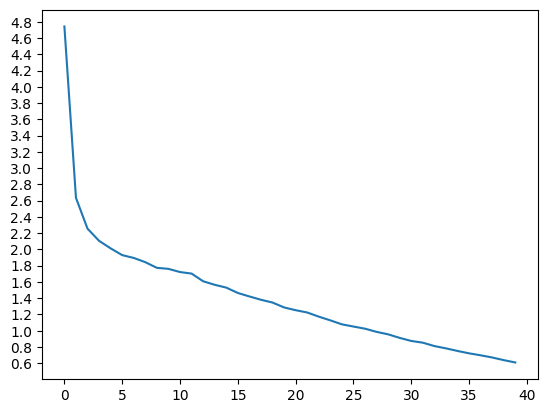

<Figure size 640x480 with 0 Axes>

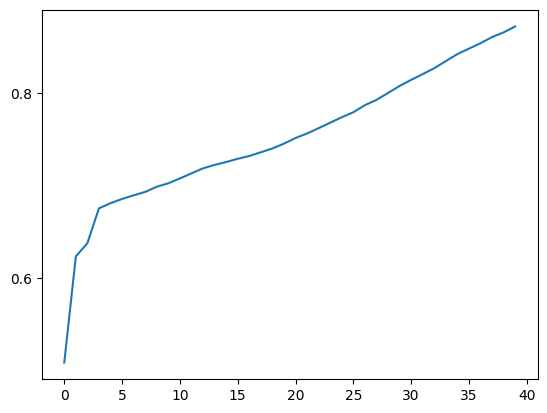

In [21]:
hidden_size = 128
batch_size = 512

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 200, print_every=5, plot_every=5)

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

0m 28s (- 46m 14s) (5 1%) 0.5428
0m 28s (- 46m 14s) (5 1%) 0.8927
0m 54s (- 44m 43s) (10 2%) 0.4890
0m 54s (- 44m 43s) (10 2%) 0.9030
1m 22s (- 44m 27s) (15 3%) 0.4640
1m 22s (- 44m 27s) (15 3%) 0.9124
1m 50s (- 44m 23s) (20 4%) 0.4301
1m 50s (- 44m 23s) (20 4%) 0.9199
2m 18s (- 43m 49s) (25 5%) 0.3962
2m 18s (- 43m 49s) (25 5%) 0.9278
2m 46s (- 43m 34s) (30 6%) 0.3715
2m 46s (- 43m 34s) (30 6%) 0.9345
3m 14s (- 43m 9s) (35 7%) 0.3433
3m 14s (- 43m 9s) (35 7%) 0.9410
3m 45s (- 43m 16s) (40 8%) 0.3207
3m 45s (- 43m 16s) (40 8%) 0.9464
4m 14s (- 42m 53s) (45 9%) 0.2938
4m 14s (- 42m 53s) (45 9%) 0.9516
4m 45s (- 42m 51s) (50 10%) 0.2758
4m 45s (- 42m 51s) (50 10%) 0.9559
5m 14s (- 42m 24s) (55 11%) 0.2519
5m 14s (- 42m 24s) (55 11%) 0.9609
5m 42s (- 41m 48s) (60 12%) 0.2316
5m 42s (- 41m 48s) (60 12%) 0.9650
6m 10s (- 41m 16s) (65 13%) 0.2167
6m 10s (- 41m 16s) (65 13%) 0.9678
6m 38s (- 40m 50s) (70 14%) 0.1989
6m 38s (- 40m 50s) (70 14%) 0.9718
7m 7s (- 40m 22s) (75 15%) 0.1800
7m 7s (-

<Figure size 640x480 with 0 Axes>

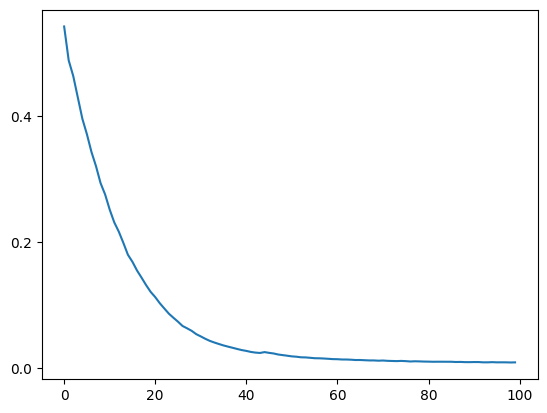

<Figure size 640x480 with 0 Axes>

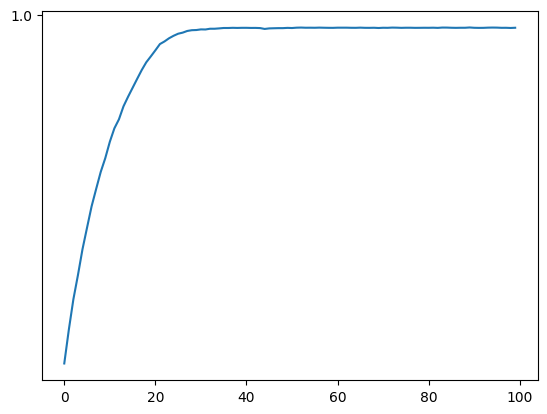

In [22]:
los, acc= train(train_dataloader, encoder, decoder, 500, print_every=5, plot_every=5)

In [23]:

import matplotlib.pyplot as plt

def plot_graph(los):
    # Calculate the x-axis ticks based on los length
    x_ticks = [(i+1)*5 for i in range(len(los))]

    # Define the custom ticks
    custom_ticks = []
    for tick in x_ticks:
      if tick % 50 == 0:
        custom_ticks.append(tick)
      else:
        custom_ticks.append('')
# plotting a graph of the loss function which shows th loss decreasing as the number of epochs increases
    plt.plot(x_ticks, los)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(x_ticks, labels=custom_ticks)  # Set custom ticks
    plt.grid(False)
    plt.show()

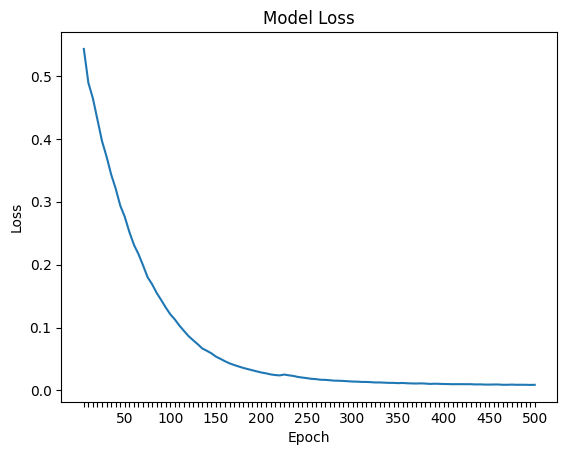

In [24]:
# plotting a graph of the loss function which shows the loss decreasing as the number of epochs increases
plot_graph(los)

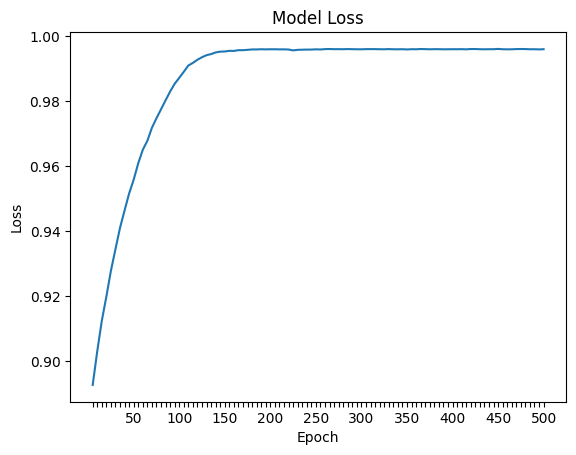

In [25]:
# plotting a graph of the accuracy function which shows the accuracy increasing as the number of epochs increases
plot_graph(acc)

In [26]:
# Save the encoder and decoder models
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> cocoa
= akaka
< kɔŋɔ a patya, ndɛm, egi bɛʼ mbyɛp-ebuŋ-nkrə a nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ

> like labor pains upon a pregnant woman, and they will not escape .
= ase, ŋwɔ gɛ kuʼɔle kəbɔ .
< ase, ŋwɔ gɛ kuʼɔle kəbɔ mbo mi e ge zɔ, ŋnya byɔnyɔŋ bənu-ndɛm bɛʼ fɛʼ bəlɛʼ gɛ a na nsaŋa

> to be
= mbə
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> until it came and stopped over the place where the child was .
= ŋbin tuŋɔ gap a bɛtelehɛm mənkrɔ nghə, “byɔ ghɔ ŋpite nfɛʼ alɨʼ za ŋwɔa mə, byɔ
< ŋbin tuŋɔ ghɔ ŋpite nfɛʼ alɨʼ za ŋwɔa mə, byɔ bənu nchɛm mi bəmɨkte nghə bə ghɔ alɨʼ a kɔ

> he was backbiting your name yesterday .
= a keh zogo mbiaŋta leliŋ loh .
< a hʉə hʉə nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ nyɛ

> if when he returns tell me .
= a bigla, o soŋ a geh .
< a hʉə hʉə ndya, ndya, ndya, ndya, ndya, ndya, ndya, achɛʼɛka ndya, ndya, mbia nchəʼ brɔgle brɔgle nchəʼ nchəʼ nchəʼ

> truth shall spring out of 

In [27]:
# saving the encoder model which is the model that converts the input language to the hidden state
torch.save(encoder.state_dict(), 'volingual_encoder.pt')

In [28]:
# saving the decoder model which is the model that converts the hidden state to the output language
torch.save(decoder.state_dict(), 'volingual_decoder.pt')

In [29]:
# Load the encoder and decoder models
encoder.load_state_dict(torch.load('volingual_encoder.pt'))
decoder.load_state_dict(torch.load('volingual_decoder.pt'))
encoder.eval()  # Set the model to evaluation mode
decoder.eval()  # Set the model to evaluation mode

AttnDecoderRNN(
  (embedding): Embedding(1675, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=1675, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
# open the test data and read the lines
test_data = open('./data/test_en.txt', 'r').readlines()
predictions = []    # Create an empty list to store the predictions
for line in test_data:   # Loop through the test data
    translation = evaluateAndShowAttention(line)   # Translate the test data
    predictions.append(translation)   # Append the translation to the predictions list

Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = He/she will cheat, you will see.

output = ebwɔ-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = He demolished a house.

output = ebwɔ-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = keep

output = ebwɔ-betat,
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = It will be good later on in the day.

output = achyɛ-byɔ a le lɔk van nfəa ijip
Reading lines...
Read 1355 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
english 1791
nweh 1675
input = Everyone was greatly surprised. But Jesus ordered them not to tell anyone what had happened.

output = ebwɔ-

In [31]:
# Specify path to save the predictions
predictions_file_path = "./data/predictions.txt"  # Path to save the predictions

# Write predictions to the file
with open(predictions_file_path, 'w') as f:
    for prediction in predictions:
        f.write(prediction + '\n')

In [32]:
# Load the nweh test data
ref_data = open('./data/test_nweh.txt', 'r').readlines()
refs = []     # Create an empty list to store the reference data
for line in ref_data:    # Loop through the reference data
    refs.append(line.split(" "))        # Append the reference data to the refs list

In [33]:
## I tried printing out the arrays to actually see what they contained

In [34]:
print(ref_data)

['À bàb-e, ò jiɔ-ɔ.\n', 'À lèh bòg ndiah.\n', 'le nale\n', 'A gʉ̀-ʉ e bɔ̀ŋ-ŋ.\n', 'ngyɛt. Jisɔs a le shuʼɔ gap nghə bó bɛʼ soŋ amɔʼ ŋwɔ, ŋ́ bin dyɔ á mbó bó nghə, “Bə ́fya ŋwɔ ́júnɛ ́ebuŋ a dʉ́.” \n', 'a le soŋɔ á gap. Eləŋ gî bó le jyɔ gi, bó le shyɛla gi, émɔʼ byɔ a nkó é le bɔŋ\n', 'le pite\n', 'gi é ghə enɛt bənu myɔ é te kwɔ lefwɔ Ndɛm bɔ́.\n', 'Ŋ kwɛ lekwɛ á mbó eshwɔ gɛ,\n', 'À fəa-a e baŋ-ŋ.\n', 'Abó-luŋɔ́za a bɔ́ŋ etyɔ́\n', 'Bɔŋ lekak á mbó Achyɛ́-byɔ,\n', 'bəbyɔ sɛk ngha á nyɛ́ Achyɛ́-byɔ. Bəbyɔ lɔk mə le bɛm-Ndɛm ŋaŋ, te ma le jyɔ elɨʼ\n', 'Tem a nyà gì!\n', 'Gò bɔ̀nɔ̀ ŋkap, gò juɔ tècìyì tèbetu.\n', 'Ŋ sɛnta Achyɛ́-byɔ nghɔ ntat ndɔk ndata anu jyɔ, nghə Satan júnɛ́ a tuŋɔ á nyɛ́\n', "À nà mbìàŋta gò tɔ̀' à gih.\n", 'À leih baŋ.\n', 'É la eləŋ mě, Jisɔs a lyɔ á mbó bajiʼi á mbó jɨ nghə, “Eləŋ gi Ŋwɔ gi a kwita\n', "Bòggò kɛ̀' mbem ŋghʉ̀ lèè jʉh se mfʉ̀'ɔ̀. \n", "Tɔgɔ ntye bi'à mbe nnɔ̀gɔ er fàh.               \n", 'Àkèndɔ̀ŋ a kei bàŋ -ŋŋ?  / Àkèndɔ̀ŋ a bàŋ m

In [35]:
print(predictions)

['ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'achyɛ-byɔ a le lɔk van nfəa ijip', 'ebwɔ-betat,', 'le ta', 'ebwɔ-betat,', 'le kwɔ', 'ebwɔ-betat,', 'achyɛ-byɔ a fya gɛ a chɛŋə lefwɔ ra', 'achyɛ-byɔ a le juʼɔ gɛ, tɛmbyɔ .”', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'le chɨ', 'achyɛ-byɔ a le lɔk nkɔŋte', 'achyɛ-byɔ a byɛba gɛ, məeta jyɔ,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'a le soŋə a mbo mə .”', 'mbagte', 'ebwɔ-betat,', 'ebwɔ-betat,', 'le saŋ', 'le tuŋ', 'ebwɔ-betat,', 'ebwɔ-betat,', 'le saŋ', 'le ta', 'ebwɔ-betat,', 'məndya map a', 'ebwɔ-betat,', 'ebwɔ-betat,', 'le kap e kuʼu, bo le fəmə,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'fwɛt-fwɛt-ndɛm a le bin nchɛʼ atɔ-ndya', 'ebwɔ-betat,', 'le jyɔ e lyɔ bap, mbaŋa', 'ebwɔ-betat,', 'abo za a bɔŋ lekak .', 'nkhangee', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'mbagte', 'a nyɛ bənu bəbɛʼ e ŋwete, ŋmbwate', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'ebwɔ-betat,', 'achyɛ-byɔ', 'le tu alɛʼ',

In [36]:
## I think there was an issue with the right use of where we imported the bleu_score. Below I imported from the Natural Language Toolkit and it works

In [37]:
from nltk.translate.bleu_score import sentence_bleu

# Calculate BLEU score for each pair of reference and prediction
total_bleu_score = 0
for ref, pred in zip(ref_data, predictions):   # Loop through the reference and prediction data
    bleu_score = sentence_bleu([ref], pred)     # Calculate the BLEU score
    total_bleu_score += bleu_score              # Add the BLEU score to the total

# Average BLEU score
average_bleu_score = total_bleu_score / len(ref_data)     # Calculate the average BLEU score
print("Average BLEU Score:", average_bleu_score)       # Print the average BLEU score

Average BLEU Score: 0.006842824844768335


/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/unix/Documents/GitHub/Volingual/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

In [38]:
## Tried out a smoothing function to get better results given that I was having issues with previous runs. Smoothing can help mitigate the issue of zero-count n-grams and provide a more accurate evaluation of the similarity between the reference and prediction data.

In [39]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define a smoothing function
smoothing_function = SmoothingFunction().method1

# Calculate BLEU score for each pair of reference and prediction
total_bleu_score = 0     # Initialize the total BLEU score
for ref, pred in zip(ref_data, predictions):      # Loop through the reference and prediction data
    bleu_score = sentence_bleu([ref], pred, smoothing_function=smoothing_function)    # Calculate the BLEU score
    total_bleu_score += bleu_score    # Add the BLEU score to the total

# Average BLEU score
average_bleu_score = total_bleu_score / len(ref_data)    # Calculate the average BLEU score
print("Average BLEU Score with Smoothing:", average_bleu_score)   # Print the average BLEU score

Average BLEU Score with Smoothing: 0.018810786972208785


In [40]:
# Commented out the previuos
# from torchtext.data.metrics import bleu_score

# bleu_score(ref_data, predictions)

In [41]:
ref_data[1]

'À lèh bòg ndiah.\n'

In [42]:
predictions[1]

'ebwɔ-betat,'